# Week 8 -- linear regression, GWAS, multiple testing
So in this week we will take a harder look at linear regression and so-called regression analysis. We will use these ideas more generally and then we will apply them to the specific case of genome-wide association studies (or GWAS) using some non-human data. Finally we will look at interpretting our results. 

## linear regression
The basic idea behind linear regression is to set up a model to explain a _dependent_ variable as a function of some _independent_ variable(s). We've looked at regressions informally earlier in this class, but now it's time to formalize our treatment. In the simplest case where both the independent and the dependent variables are 1 dimensional, call them $X$ and $Y$ respectively, then a linear regression model takes the form
$$ 
Y = \beta_0 + \beta_1 X + e
$$

where we call $\beta_0$ the intercept, $\beta_1$ the coefficient of our model (i.e. the slope of our line), and $e$ the noise term. Notice this is *exactly* equivalent to fitting a slope and intercept to some data to get a best fit straight line.

Note that such linear regression can be more complex. $X$ could be a matrix of independent variables, rather than just a vector of a single variable. If that is the case then $\beta_1$ itself becomes vector valued, corresponding to the case where we have coefficients associated with each of variables in $X$.

## Phenotype data from _Arabidopsis thaliana_
The data we will play with today from the genetic model plant _Arabidopsis thaliana_. _Arabidopsis thaliana_ has been an incredible workhorse for genetics and quantitative genetics in particular. This is so because it has a very fast generation time, a simple genome, and an excellent community of researchers behind it that *share their data*. As a result, I am able to get sets of genotypes and phenotypes from a number of different accessions that we might play with in class. First let's import the phenotype data and explore it alone

In [1]:
# imports for this notebook
import sys
import numpy as np
import scipy as sp
import scipy.stats as st
import pandas as pd
import h5py
from matplotlib import pylab as plt
import seaborn as sns
import limix
sns.set_style('darkgrid')

the data we will bring in is stored in a cool file format called _hdf5_. Don't sweat the details here but know that these are very efficient files for reading and writing data quickly. We will bring in the data and stuff it into a pandas dataframe

In [2]:
# get data
f = h5py.File("data/atwell_107.hdf5", 'r')
phenotype_names = ['5_FT10','6_FT16','7_FT22']
pheno_group = f['phenotype']
pheno_df = pd.DataFrame(pheno_group['matrix'][:], 
                        columns=[x.decode('utf-8') for x in pheno_group['col_header']['phenotype_ID'][:]],
                        index=pheno_group['row_header']['sample_ID'][:])[phenotype_names]
pheno_df.head()

,5_FT10,6_FT16,7_FT22
5837,57.0,50.0,43.0
6008,60.0,41.0,24.0
6009,98.0,151.0,250.0
6016,75.0,101.0,113.0
6040,71.0,92.0,87.0


these phenotypes that we have just imported are flowering time for the plants at different temperatures. For instance FT_16 is the flowering time (in days) for plants at 16 degrees Celsius. Let's plot these data against one another using seaborns pairplot function

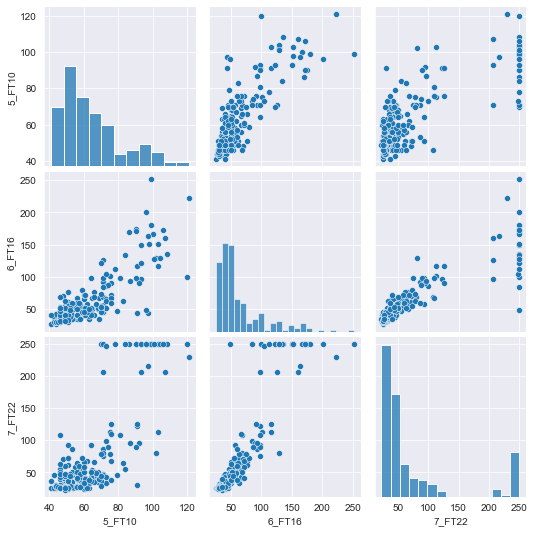

In [3]:
sns.pairplot(pheno_df)

so by eye, flowering time at different temperatures _seems_ closely correlated. We will look at this using regression!

For this we will use `scipy` function `linregress` which will do all the hard work for us 


 slope: 1.8319005222486742
 intercept: -52.34761211003709
 r_value: 0.8056022709697921
 p_value: 2.6973898842840255e-45


/Users/adk/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


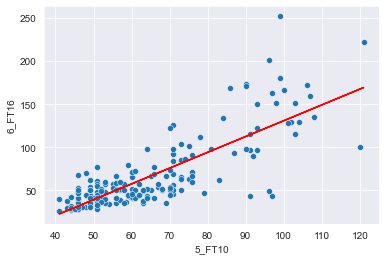

In [4]:
#mask out NAs, do regression
mask = ~np.isnan(pheno_df['5_FT10']) & ~np.isnan(pheno_df['6_FT16'])
slope, intercept, r_value, p_value, std_err = st.linregress(pheno_df[mask]['5_FT10'],pheno_df[mask]['6_FT16'])
print(f" slope: {slope}\n intercept: {intercept}\n r_value: {r_value}\n p_value: {p_value}")

#now plot the relationship
sns.scatterplot(pheno_df[mask]['5_FT10'],pheno_df[mask]['6_FT16'])
preds = [ intercept + (slope * x) for x in pheno_df[mask]['5_FT10']]
plt.plot(pheno_df[mask]['5_FT10'],preds,color='red')

so we can see that there is a strong relationship among these two phenotypes. A few notes about what we have output above:
1. the slope above is the coefficient of out regression, i.e. the $\beta_1$ value above
2. the r-value tells us about the strength of the relationship. it varies between 0 and 1 with 1 indicated a perfect association. Generally people present the value of $r^2$ a.k.a. the coefficient of determination. $r^2$ tells us the percentage of variation explained by the regression.
3. the p-value listed above tells us the significance of the coefficient, i.e. the probability that it is different from zero. Where does this come from? Well it comes from doing a T-test of the hypothesis that $\beta_1 = 0$

In [5]:
# calculate R-square
print(f" R-squared equals: {r_value **2}")

 R-squared equals: 0.6489950189916863


so in sum then, our model accounts for approximately 64% of the variation and we find a significant relationship between flowering time at 10 degrees and flowering time at 16 degrees. 

Ask yourself the very important questions: is this relationship *causal*? Does FT10 directly change FT16?

---------------

## GWAS
To do GWAS we will be doing a regression of phenotypes onto genotypes. That is will will ask if genotype is correlated with phenotype for each SNP in the genome. So let's bring in the genotypes that go along with this phenotypes.

By the way, will use a python package for GWAS that is very fast. the package we will use is called `limix` and you can read more about it [here](https://docs.limix.io/en/latest/)

In [6]:
geno_group = f['genotype']
chromosomes = geno_group['col_header']['chrom'][::10]
positions = geno_group['col_header']['pos'][::10]
geno_df = pd.DataFrame(geno_group['matrix'][:,::10], columns=positions, 
                       index=geno_group['row_header']['sample_ID'][:],
                      dtype='float64')
print(f" shape of geno_df: {geno_df.shape}")
geno_df.head()

 shape of geno_df: (1179, 21456)


,657,7601,13045,25365,31926,41427,48118,55684,62259,69311,...,26931730,26934779,26937502,26941289,26945443,26951228,26957649,26964341,26969880,26973598
6122,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
6121,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6119,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6116,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
6115,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


okay so we've got 1179 individuals that have been genotyped at 21456 SNPs. That's a huge haul of data!

Next let's line up these individuals with the phenotype data, and along the way let's clean up those NaNs in the phenotype matrix by using pandas helpful `.dropna()` function

In [7]:
#Remove NaNs
filtered_pheno_df = pheno_df.dropna()
filtered_pheno_df.info()
sample_idx = geno_df.index.intersection(filtered_pheno_df.index)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192 entries, 5837 to 100000
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   5_FT10  192 non-null    float64
 1   6_FT16  192 non-null    float64
 2   7_FT22  192 non-null    float64
dtypes: float64(3)
memory usage: 6.0 KB


let's look at the intersection here-- what do we have left after filtering

In [8]:
print(f"shape of intersection is {sample_idx.shape}")

shape of intersection is (192,)


okay so now we are down to 192 individuals for whom we had the flower time phenotypes and genotype data. We will continue in this limited sample.

My first step in GWAS will be to normalize the phenotypes. I'm going to do this by subtracting off the means and dividing by the standard deviations. limix of course can do this for me.

(192, 21456)
(192, 3)


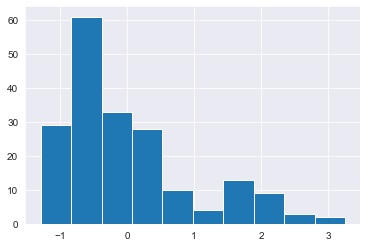

In [9]:
phenotype_std = limix.qc.mean_standardize(filtered_pheno_df.loc[sample_idx].values)
snps = geno_df.loc[sample_idx]
plt.hist(phenotype_std[:,0])
print(snps.shape)
print(phenotype_std.shape)

okay we are now ready to run!

# Limix GWAS analysis
the interface to GWAS is a bit clunky with limix, but not terrible. Basically we have gotten all our data in the correct shape so we are now ready to use the `scan` function that will do all the heavy lifting and return all of our stats

In [10]:
# running the analysis
# GWAS for FT10
lm_ft10 = limix.qtl.scan(snps.values,phenotype_std[:,0],verbose=True)
lm_ft10.stats.head()

================================= QTL analysis starts ==================================

Normalising input... 
done (1.01 seconds).

Input
-----

Likelihood       : normal
Traits (1)       : [0]
Covariates (1)   : ['offset']
Variants 21456   : [0, 1, 2, ..., 21455]
N. of candidates : 21456
Kinship          : absent



/Users/adk/miniconda3/lib/python3.7/site-packages/limix/_data/_conform.py:249: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import InvalidIndexError
Results: 100%|██████████| 21456/21456 [00:00<00:00, 33386.81it/s]



Hypothesis 0
------------

𝐲 ~ 𝓝(𝙼𝜶, 1.000⋅𝙸)

M     = ['offset']
𝜶     = [-1.45716772e-16]
se(𝜶) = [0.07216878]
lml   = -272.43619837529707

Hypothesis 2
------------

𝐲 ~ 𝓝(𝙼𝜶 + G𝛃, s(1.000⋅𝙸))

          lml       cov. effsizes   cand. effsizes
--------------------------------------------------
mean   -2.707e+02      -2.469e-03        2.567e-04
std     2.620e+00       8.094e-02        3.611e-01
min    -2.724e+02      -4.348e-01       -1.179e+00
25%    -2.723e+02      -4.531e-02       -2.557e-01
50%    -2.717e+02       5.433e-03       -3.182e-02
75%    -2.703e+02       4.360e-02        2.128e-01
max    -2.317e+02       4.173e-01        1.761e+00

Likelihood-ratio test p-values
------------------------------

       𝓗₀ vs 𝓗₂ 
----------------
mean   3.136e-01
std    3.045e-01
min    1.712e-19
25%    3.662e-02
50%    2.106e-01
75%    5.459e-01
max    9.999e-01


========================== QTL analysis ends in 2.14 seconds ===========================

,lml0,lml2,dof20,scale2,pv20
test,,,,,
0,-272.436198,-260.702143,1,0.884945,0.000001
1,-272.436198,-271.889630,1,0.994323,0.295777
2,-272.436198,-271.510781,1,0.990407,0.173686
3,-272.436198,-272.291651,1,0.998495,0.590801
4,-272.436198,-272.390531,1,0.999524,0.762488


and GWAS is complete! that was super each, we now have p-values associated with each SNP in our dataset for the FT10 phenotype. We also have the estimates of $\beta$ (effect sizes) associated with each SNP. Let's plot the distribution of p-values

Text(0.5, 0, 'P-value')

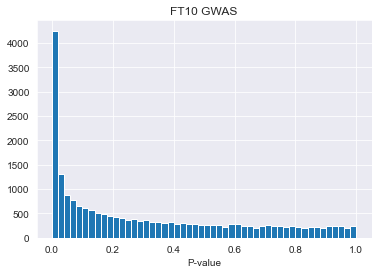

In [11]:
lm_ft10.stats.pv20.hist(bins=50)
plt.title("FT10 GWAS")
plt.xlabel("P-value")

you'll notice that the distribution here is heavily skewed towards *low* p-values. That's a good thing! It means that there are true positives in our dataset. If we made up a fake phenotype this distribution would look quite different. 

### a fake phenotype
So let's quickly make up a fake phenotype that is just normally distributed random variables without any connection to the genotype and then we will examine the distribution of p-values that results

<AxesSubplot:>

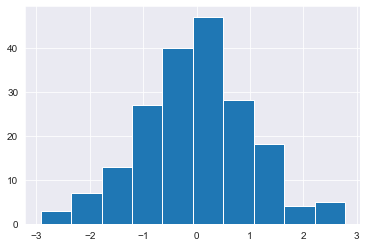

In [12]:
fake = pd.DataFrame()
fake['fake_pheno'] = np.random.normal(size=192)
fake.fake_pheno.hist()

okay we have our fake phenotype, let's do GWAS with it

Text(0.5, 0, 'P-value')

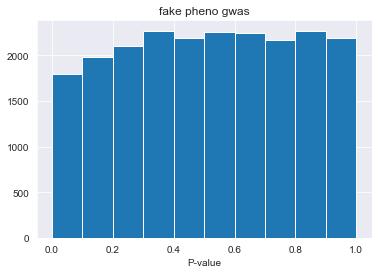

In [13]:
# running the analysis
# GWAS for Fake pheno
gwas_fake = limix.qtl.scan(snps.values,fake.fake_pheno,verbose=False)
gwas_fake.stats.pv20.hist()
plt.title("fake pheno gwas")
plt.xlabel("P-value")

okay so we see that this distribution is really different! p-values are now uniformly distributed between zero and one; there is no enrichment towards low p-values. 

But this raises a question? Why are there still p-value less that $p=0.05$ if there is no true association? The answer is False Positives!

## The problem of multiple testing
A very big issue arises then-- if the probability of a false positive is nonzero, that means that when we do a bunch of statistical tests we should _expect_ false positives. For instance, imagine the probability of a false positive in some statistical tests was 5%. If we perform this test 20 times, how many false positives might we expect? Well $0.05 \times 20 = 1$ false positive test in our experiment. If we did the same test 100 times we would expect 5 false positives, and so on. 

This suggests a very simple fix for our problem of doing the same test many times-- what if we adjust the critical value of our test to deal with the number independent tests we are doing? This is what is known as the [Bonferroni correction](https://en.wikipedia.org/wiki/Bonferroni_correction) For instance if our critical value is $\alpha = 0.05$ and we do $m$ comparisons, we could simply adjust a critical value to $b = \alpha / m$. So if $\alpha = 0.05$ and we do 100 independent tests, the Bonferroni corrected significance threshold would be $p = 0.0005$. 

Let's take this idea out for a spin on the FT_10 GWAS analysis. First we will count the number of significant tests at the nominal $p=0.05$ cutoff.

In [14]:
print(f"number of tests (SNPs): {len(lm_ft10.stats)}")
print(f"number of sig. tests p < 0.05: {np.sum(lm_ft10.stats.pv20 < 0.05)}")
print(f"number of sig. tests after Bonferroni: {np.sum(lm_ft10.stats.pv20 < (0.05/len(lm_ft10.stats)))}")

number of tests (SNPs): 21456
number of sig. tests p < 0.05: 6022
number of sig. tests after Bonferroni: 313


so we can see that the Bonferroni correction is telling us that if we are conservative there are many _fewer_ significant SNPs than if we did not deal with the number of independent tests that we are doing

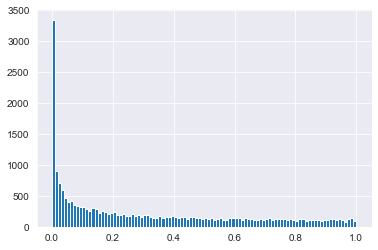

In [18]:
lm_ft10.stats.pv20.hist(bins=100)
bf_corr = 0.05 / 21456
plt.plot([bf_corr,bf_corr],[0,1],"r")

### Q-Q Plots to look for enrichment
Another way to visualize an enrichment of significant tests is through what's called a [Quantile-Quantile Plot](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot) (or Q-Q Plot). Q-Q Plots shows two probability distributions compared one to another, aligning them by the quantile values of their individual points. If the distributions are identical then we expect a Q-Q plot to create a straight line along the diagonal. 

Generally we use Q-Q Plots in GWAS to compare the distribution of p-values between the true analysis and the uniform assumption of no association. We can again do this using `limix`

Text(0.5, 1.0, 'FT10 QQ Plot')

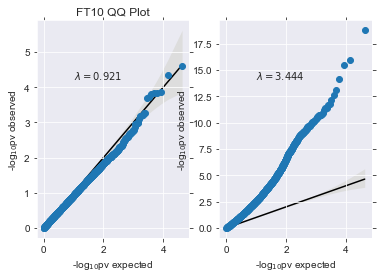

In [19]:
fig, ax = plt.subplots(1,2)
limix.plot.qqplot(gwas_fake.stats.pv20, ax=ax[0])
ax[0].set_title("Fake Pheno QQ Plot")
limix.plot.qqplot(lm_ft10.stats.pv20, ax=ax[1])
ax[0].set_title("FT10 QQ Plot")

Okay so on the left here I'm showing the Q-Q plot for a fake phenotype, whereas on the right I'm showing the Q-Q plot for the FT10 phenotype. You can see that the fake phenotype follows the 1:1 line, signifying that there is no enrichment of significant tests. However, on the right hand side we see that the observed values are growing much more quickly than the expected, suggesting a significant enrichment of small p-values in the true data. I.e., there are some SNPs associated with flowering time in our data!

### Manhattan Plots
The most common visualization for GWAS results is what is know as a Manhattan plot, so named because of how the peaks in negative log p-values create a skyline resembling tall buildings in Manhattan! The visualization plots the p-value at each SNP examined versus location on the chromosome. Negative log p-values are displayed so the _most_ significant tests are _highest_ on the plot.

Let's look at the Manhattan plot for the FT10 phenotype. I will add a red horizontal line which shows the Bonferroni corrected significance threshold.

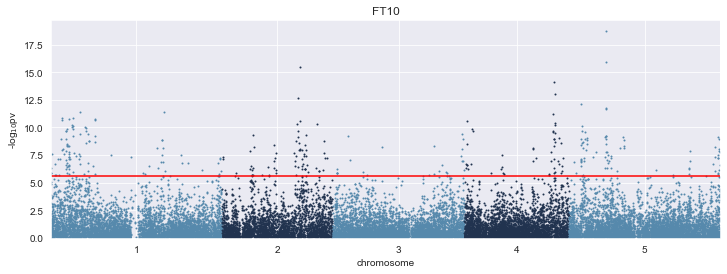

In [20]:
plt.figure(figsize=[12,4])
plt.title("FT10")
limix.plot.manhattan(pd.DataFrame(dict(pv=lm_ft10.stats.pv20,chrom=chromosomes,pos=positions)))
bc = 0.05 / len(lm_ft10.stats.pv20)
plt.axhline(-np.log10(bc), color='red')

just for completeness lets plot similar for the fake phenotype GWAS

(0.0, 10.0)

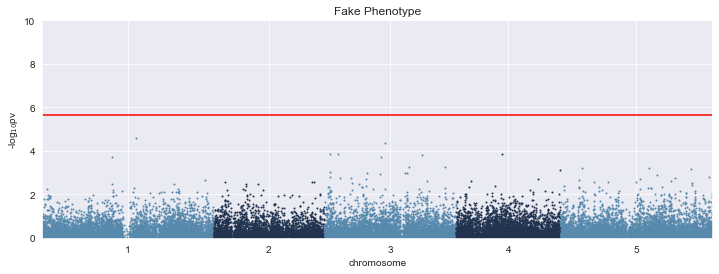

In [21]:
plt.figure(figsize=[12,4])
plt.title("Fake Phenotype")
limix.plot.manhattan(pd.DataFrame(dict(pv=gwas_fake.stats.pv20,chrom=chromosomes,pos=positions)))
bc = 0.05 / len(lm_ft10.stats.pv20)
plt.axhline(-np.log10(bc), color='red')
plt.ylim(0,10)

note that *none* of the SNPs are now above the critical value for our fake phenotype

## Effects sizes
Statistical significance is only one small part of associating a SNP with a phenotype. Equally important is getting a decent handle on the effect size, the $\beta$ value, of the associated SNPs. Recall however that we get this for free out of our regression analysis. Let's take a look at the effect size distributions, for our FT10 phenotype and our fake phenotype.

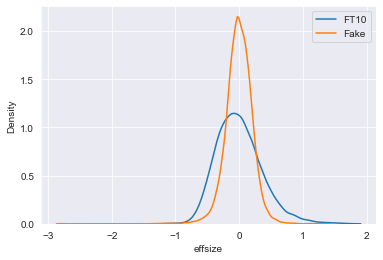

In [22]:
# limix stores candidate and covariate effects separately,
# candidate here refers to the SNP effect (i.e. slope) rather than the intercept

betas_mask = lm_ft10.effsizes['h2']['effect_type'] == 'candidate'
betas_ft10 = lm_ft10.effsizes['h2'][betas_mask]

betas_mask = gwas_fake.effsizes['h2']['effect_type'] == 'candidate'
betas_fake = gwas_fake.effsizes['h2'][betas_mask]

# visualize the distributions
sns.kdeplot(betas_ft10.effsize)
sns.kdeplot(betas_fake.effsize)
plt.legend(["FT10","Fake"])

**Exercise:** Interpret this plot. Why are these effect size distributions different from one another? What do you notice about the tails of the FT10 distribution in comparison to the fake phenotype?

## Comparing phenos at large effect SNPs
Next let's compare phenotypes of individuals at SNPs of large effect. 

In [23]:
# get the maximum absolute effect size snp
imax = np.abs(np.array(lm_ft10.effsizes['h2']['effsize'])).argmax()
beta = lm_ft10.effsizes['h2'].effsize[imax]
snps.head()
#snps['FT10'] = phenotype_std[:,0]
#sns.boxenplot(x=snps[snps.FT10,)

,657,7601,13045,25365,31926,41427,48118,55684,62259,69311,...,26931730,26934779,26937502,26941289,26945443,26951228,26957649,26964341,26969880,26973598
8264,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8265,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
8274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6899,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
8230,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


/Users/adk/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'phenotype')

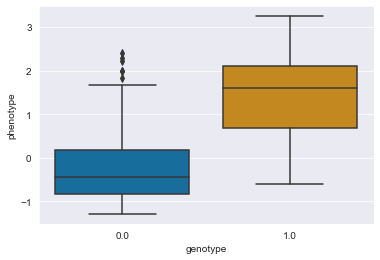

In [24]:
#pheno_vals = filtered_pheno_df['5_FT10']
#s_idx = geno_df.index.intersection(pheno_vals.index)
imax = lm_ft10.stats.pv20.idxmin()

snp = geno_df.loc[sample_idx][geno_df.columns[imax]]

#plot SNP vs. phenotype for max beta
sns.boxplot(snp,phenotype_std[:,0], palette="colorblind")
plt.xlabel("genotype")
plt.ylabel("phenotype")


In [25]:
z = f['phenotype']['col_header']['phenotype_ID']

## So why so many positives here?
If we consider flowering time at 10 degrees for a second, why are there significant hits in our GWAS scan above? Do we need to worry about things, even though we've performed a correction for multiple tests?

Well in short-- maybe. There are lots of things that could go wrong with our GWAS study. Perhaps the ubiquitous issue with GWAS is hidden _population structure_ in our sample that we haven't accounted for. For instance, imagine the phenotype in question changed over the landscape of the organism. If genetic differentiation occurs among localities then we would expect spurious associations between genotype and phenotype throughout the genome.

Well is there population structure in Arabidopsis? Does that structure coincide with phenotypic variation?

Well it just so happens I've got a bunch of metadata about these samples that we can use. I've stored the metadata in `data/araThal_meta.csv`. Let's bring in that metadata and intersect it with our phenotypic data. 

In [26]:
meta = pd.read_csv("data/araThal_meta.csv")
meta.index = meta.pk

phenotype_names = ['5_FT10']
pheno_group = f['phenotype']
pheno_df = pd.DataFrame(pheno_group['matrix'][:], 
                        columns=[x.decode('utf-8') for x in pheno_group['col_header']['phenotype_ID'][:]],
                        index=pheno_group['row_header']['sample_ID'][:])[phenotype_names]
pheno_df.head()


#Remove NaNs
filtered_pheno_df =  pheno_df.dropna()
filtered_pheno_df = filtered_pheno_df.join(meta) 
#filtered_pheno_df.info()
sample_idx = geno_df.index.intersection(filtered_pheno_df.index)
filtered_pheno_df.head()

,5_FT10,pk,name,country,latitude,longitude,collector,collection_date,cs_number,species,genotypes,count_phenotypes
5837,57.0,5837,Bor-1,Czech Republic,49.4013,16.2326,Jirina Relichov,NaN,CS76453,Arabidopsis thaliana,NaN,318
6008,60.0,6008,Duk,Czech Republic,49.1000,16.2000,Jirina Relichov,NaN,CS76824,Arabidopsis thaliana,NaN,356
6009,98.0,6009,Eden-1,Sweden,62.8770,18.1770,Magnus Nordborg,NaN,CS76826,Arabidopsis thaliana,NaN,135
6016,75.0,6016,Eds-1,Sweden,62.9000,18.4000,Magnus Nordborg,NaN,CS76834,Arabidopsis thaliana,NaN,143
6040,71.0,6040,Kni-1,Sweden,55.6600,13.4000,Magnus Nordborg,NaN,CS76970,Arabidopsis thaliana,NaN,317


okay so now we have a lot of new information including the country where the plant was collected and the latitude and longitude position of that sampling. 

Let's plot this quickly on a map

In [27]:
import folium
m = folium.Map(location=[0, 40], zoom_start=1)
for index, row in filtered_pheno_df.iterrows():
    if not np.isnan(row.longitude):
        # print([row.longitude, row.latitude])
        folium.Marker([row.latitude, row.longitude],popup=row.country).add_to(m)
m

so clearly there is a lot of geographical variation in the sampling that has been done here. that is a feature and not a bug however we have to account for that variation somehow. First let's check if there is a correlation between our phenotype (flowering time) and latitude. One might naively expect this if plants become locally adapted, because summer is shorter at higher latitudes so plants need to flower more quickly.

Text(0.5, 1.0, 'coefficient of determination: 0.2836135523022946')

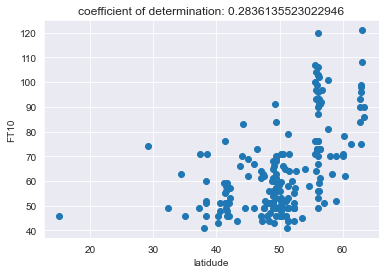

In [28]:
plt.scatter(filtered_pheno_df.latitude,filtered_pheno_df['5_FT10'])
plt.xlabel("latidude")
plt.ylabel("FT10")
r = filtered_pheno_df.latitude.corr(filtered_pheno_df['5_FT10'])
plt.title(f'coefficient of determination: {r**2}')

oh crap! our phenotype **is** correlated with the sampling. if this extends down to the level of the genotype we are in trouble. 

To deal with this we will correct our regression by accounting for population structure and using some representation of that structure as a *covariate* in our regressions. Covariates are just further terms we can add to our regression equation to _control_ for stratification in our sample. Sometimes this is called Multiple Regression, because we will ultimately estimate coefficients for these covariates as well as the variables of interest.

A regression with covariates might take the following form
$$ 
Y = \beta_0 + \beta_1 X + \beta_2 M + e
$$

where M is now a matrix (or vector) of covariates that get included in our regression. When we fit our model, we learn the associated vector of parameters $\beta_2$, and so can explicitly include our covariates in the predictions.

## PCA to deal with population structure
The simplest way for us to deal with population structure is to do a PCA analysis of our genotypes, and then use their positions in PCA space as covariates in a regression

In [31]:
from sklearn.decomposition import PCA
pc = PCA()
pc_snps = pc.fit_transform(snps)

### Plot the top two PCs from PCA of the SNPs
Note that this is a two-dimensional representation of the genotype data

Text(0, 0.5, 'PCA2')

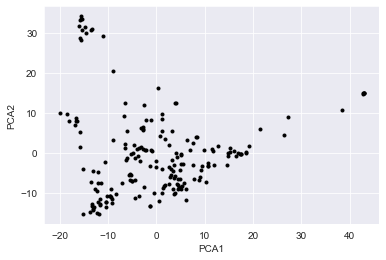

In [32]:
plt.plot(pc_snps[:,0],pc_snps[:,1],'k.')
plt.xlabel('PCA1')
plt.ylabel('PCA2')

### Plot the proportion (%) of variance explained by each PC

Text(0, 0.5, 'total variance explained')

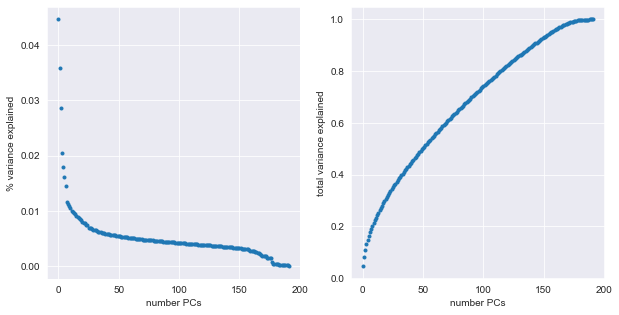

In [33]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(pc.explained_variance_ratio_, ".")
plt.xlabel("number PCs")
plt.ylabel("% variance explained")

plt.subplot(1,2,2)
plt.plot(pc.explained_variance_ratio_.cumsum(), ".")
plt.xlabel("number PCs")
plt.ylabel("total variance explained")

### Running a linear model with PC correction

Here, we perform GWAS using principal components (after PCA of the genotype matrix) in an attempt to correct for confounding due to population structure. Like earlier, we use QQ-plots to check for (possible) P-value inflation.

In [34]:
covs_with_pcs = sp.concatenate([sp.ones([snps.shape[0],1]),pc_snps],axis=1)
n_components = [0,5,10,60]

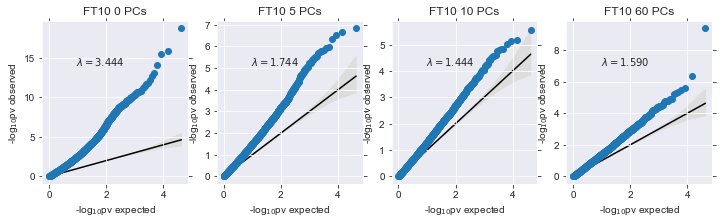

In [36]:
fig, axs = plt.subplots(1, 4,figsize=(12,3))

idx = 0

for i in n_components:
    _covs = covs_with_pcs[:,0:i+1]
    # print(_covs.shape,snps.values.shape,phenotype_std.shape)
    g = limix.qtl.scan(snps.values,phenotype_std[:,0],M=_covs,verbose=False)
    
    limix.plot.qqplot(g.stats.pv20,ax=axs[idx])
    axs[idx].set_title(f'FT10 {i} PCs')
    idx += 1
        


So we can see that as we include more PCs as covariates, the number of significant tests keeps decreasing! This is a sure sign that we have problems with population structure in our sample. Let's take a quick look at the Manhattan plots to confirm that false positives are going away as we include covariates



(0.0, 10.0)

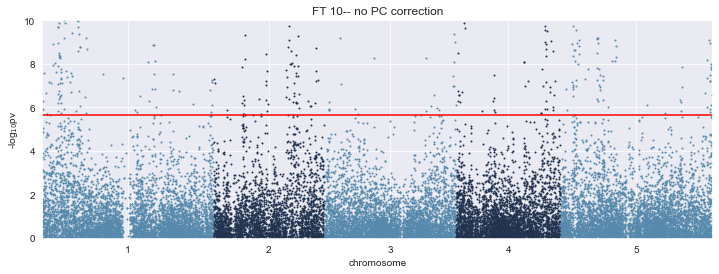

In [37]:
plt.figure(figsize=[12,4])
plt.title("FT 10-- no PC correction")
limix.plot.manhattan(pd.DataFrame(dict(pv=lm_ft10.stats.pv20,chrom=chromosomes,pos=positions)))
bc = 0.05 / len(lm_ft10.stats.pv20)
plt.axhline(-np.log10(bc), color='red')
plt.ylim(0,10)

(0.0, 10.0)

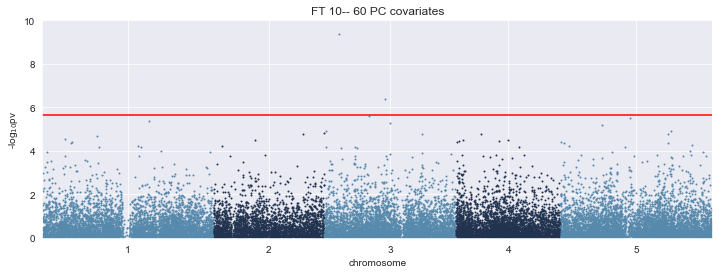

In [38]:
plt.figure(figsize=[12,4])
plt.title("FT 10-- 60 PC covariates")
limix.plot.manhattan(pd.DataFrame(dict(pv=g.stats.pv20,chrom=chromosomes,pos=positions)))
bc = 0.05 / len(lm_ft10.stats.pv20)
plt.axhline(-np.log10(bc), color='red')
plt.ylim(0,10)

### Well there go our hits!
Let's quickly look at the effect size distribution for SNP effects in the corrected versus uncorrected GWAS

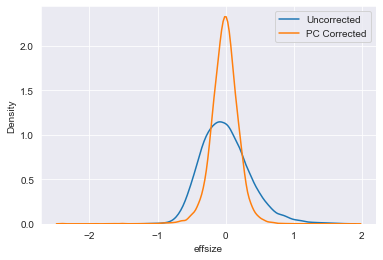

In [39]:
# limix stores candidate and covariate effects separately,
# candidate here refers to the SNP effect (i.e. slope) rather than the intercept

betas_mask = lm_ft10.effsizes['h2']['effect_type'] == 'candidate'
betas_ft10 = lm_ft10.effsizes['h2'][betas_mask]

betas_mask = g.effsizes['h2']['effect_type'] == 'candidate'
betas_corr = g.effsizes['h2'][betas_mask]

# visualize the distributions
sns.kdeplot(betas_ft10.effsize)
sns.kdeplot(betas_corr.effsize)
plt.legend(["Uncorrected","PC Corrected"])

# Polygenic scores
An increasingly popular thing to do with GWAS data is to take the SNP effect size estimates, i.e., the $\beta$'s, and sum those up for a given genotype to make a prediction as to what that individuals phenotype should be from their genotype

r-squared: 0.5979035822729089 p-value: 1.9210442944225653e-39


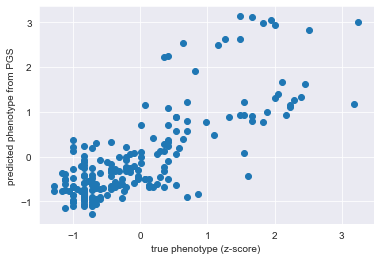

In [42]:
def polygenic_score(genotype, betas):
    pgs = 0
    for i,x in enumerate(genotype):
        pgs += (x * betas[i])
    return(pgs)

betas_mask = lm_ft10.effsizes['h2']['effect_type'] == 'covariate'
covs_ft10 = lm_ft10.effsizes['h2'][betas_mask]

n = snps.shape[0]
pgs = np.zeros(n)
for i in range(n):
    pgs[i] = polygenic_score(snps.iloc[i],betas_ft10.effsize.values)
  
# standardize PGS
pgs -= np.mean(pgs)
pgs /= np.std(pgs)
plt.scatter(phenotype_std[:,0], pgs)
plt.xlabel("true phenotype (z-score)")
plt.ylabel("predicted phenotype from PGS")

slope, intercept, r_value, p_value, std_err = st.linregress(phenotype_std[:,0],pgs)
print(f'r-squared: {r_value **2} p-value: {p_value}')
